In [ ]:
!pip install torch_geometric

In [ ]:
import torch
import numpy                    as     np
import networkx                 as     nx
import matplotlib.pyplot        as     plt
from   torch_geometric.datasets import KarateClub
from   torch_geometric.utils    import to_dense_adj
from   torch_geometric.utils    import to_networkx
from   torch.nn                 import Linear
from   torch_geometric.nn       import GCNConv

In [ ]:
dataset = KarateClub()

print(dataset)
print('------------')
print(f'Number of graphs  : {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes : {dataset.num_classes}')
print(f'Dimension         : {dataset.x.shape}')

# I nodi non hanno proprietà specifiche. Hanno soltanto un 1 in corrispondenza
# del proprio indice. Quindi classificheremo i nodi soltanto sulla base delle
# proprie connessioni.
print(dataset.x)

KarateClub()
------------
Number of graphs  : 1
Number of features: 34
Number of classes : 4
Dimension         : torch.Size([34, 34])
tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.]])


In [ ]:
# Stampiamo gli archi. Essi vengono rappresentati attraverso un tensore
# aventi due dimensioni:
#   - la prima indica sorgente o destinazione
#   - la seconda indica il numero di archi.
print(f'edge_index = {dataset.edge_index.shape}')
print(dataset.edge_index)

# Una seconda modalità di rappresentazione è attraverso la matrice di adiacenza.
# Tensore avente due dimensioni, dove sia la prima che la seconda rappresentano
# il mumero di nodi. L'elemento i,j è diverso da 0 se esiste un arco tra i due
# nodi.
A = to_dense_adj(dataset.edge_index)
print(f'\nA = {A.shape}')
print(A)

edge_index = torch.Size([2, 156])
tensor([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,
          1,  1,  1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  3,
          3,  3,  3,  3,  3,  4,  4,  4,  5,  5,  5,  5,  6,  6,  6,  6,  7,  7,
          7,  7,  8,  8,  8,  8,  8,  9,  9, 10, 10, 10, 11, 12, 12, 13, 13, 13,
         13, 13, 14, 14, 15, 15, 16, 16, 17, 17, 18, 18, 19, 19, 19, 20, 20, 21,
         21, 22, 22, 23, 23, 23, 23, 23, 24, 24, 24, 25, 25, 25, 26, 26, 27, 27,
         27, 27, 28, 28, 28, 29, 29, 29, 29, 30, 30, 30, 30, 31, 31, 31, 31, 31,
         31, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 33, 33, 33, 33, 33,
         33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33],
        [ 1,  2,  3,  4,  5,  6,  7,  8, 10, 11, 12, 13, 17, 19, 21, 31,  0,  2,
          3,  7, 13, 17, 19, 21, 30,  0,  1,  3,  7,  8,  9, 13, 27, 28, 32,  0,
          1,  2,  7, 12, 13,  0,  6, 10,  0,  6, 10, 16,  0,  4,  5, 16,  0,  1,
          2,  3, 

In [ ]:
# Stampiamo la classe di appartenenza di ogno nodo
print(f'y = {dataset.y.shape}')
print(dataset.y)

# Altri metadata
print(f'\nEdges are directed      : {dataset[0].is_directed()}')
print(f'Graph has isolated nodes: {dataset[0].has_isolated_nodes()}')
print(f'Graph has loops         : {dataset[0].has_self_loops()}')

y = torch.Size([34])
tensor([1, 1, 1, 1, 3, 3, 3, 1, 0, 1, 3, 1, 1, 1, 0, 0, 3, 1, 0, 1, 0, 1, 0, 0,
        2, 2, 0, 0, 2, 0, 0, 2, 0, 0])

train_mask = torch.Size([34])
tensor([ True, False, False, False,  True, False, False, False,  True, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False,  True, False, False, False, False, False,
        False, False, False, False])

Edges are directed      : False
Graph has isolated nodes: False
Graph has loops         : False


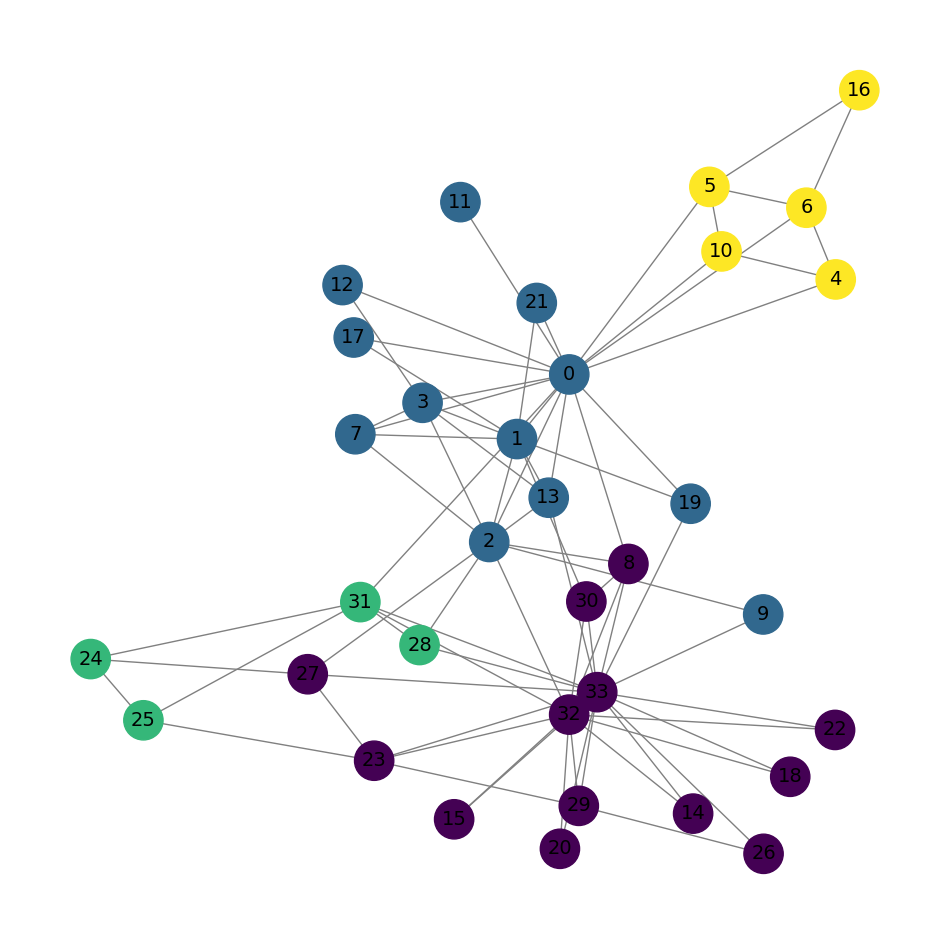

In [ ]:
# Plottiamo il grafo
G = to_networkx(dataset[0], to_undirected=True)
plt.figure(figsize=(12,12))
plt.axis('off')
nx.draw_networkx(G,
                pos=nx.spring_layout(G, seed=0),
                with_labels=True,
                node_size=800,
                node_color=dataset.y,
                edge_color="grey",
                font_size=14
                )
plt.show()

In [ ]:
# Definiamo il modello:
# Viene creata una GNN con un singolo livello convoluzionale, una funzione di
# attivazione ReLU, ed infine un livello lineare. In uscita avremmo un tensore
# matriciale dove la prima dimensione indica il numero di nodi, mentre la seconda
# il numero di classi. Il valore della cella (i,j) indica con quale probabilità
# i possa essere classificato con j.
# Il livello convoluzionale restituisce un hidden layer a 3 dimensioni.
class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.gcn = GCNConv(dataset.num_features, 3)
        self.out = Linear(3, dataset.num_classes)

    def forward(self, x, edge_index):
        h = self.gcn(x, edge_index).relu()
        z = self.out(h)
        return h, z

model = GCN()
print(model)

GCN(
  (gcn): GCNConv(34, 3)
  (out): Linear(in_features=3, out_features=4, bias=True)
)


In [ ]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.02)

# Calculate accuracy
def accuracy(pred_y, y):
    return (pred_y == y).sum() / len(y)

# Data for animations
embeddings = []
losses     = []
accuracies = []
outputs    = []

# Training loop
for epoch in range(201):
    # Clear gradients
    optimizer.zero_grad()

    # Forward pass
    h, z = model(dataset.x, dataset.edge_index)

    # Calculate loss function
    loss = criterion(z, dataset.y)

    # Calculate accuracy
    acc  = accuracy(z.argmax(dim=1), dataset.y)

    # Compute gradients
    loss.backward()

    # Tune parameters
    optimizer.step()

    # Store data for animations
    embeddings.append(h)
    losses.append(loss)
    accuracies.append(acc)
    outputs.append(z.argmax(dim=1))

    if epoch % 10 == 0:
        print(f'Epoch {epoch:>3} | Loss: {loss:.2f} | Acc: {acc*100:.2f}%')

Epoch   0 | Loss: 1.33 | Acc: 35.29%
Epoch  10 | Loss: 1.19 | Acc: 64.71%
Epoch  20 | Loss: 1.01 | Acc: 50.00%
Epoch  30 | Loss: 0.79 | Acc: 61.76%
Epoch  40 | Loss: 0.57 | Acc: 88.24%
Epoch  50 | Loss: 0.38 | Acc: 100.00%
Epoch  60 | Loss: 0.24 | Acc: 100.00%
Epoch  70 | Loss: 0.14 | Acc: 100.00%
Epoch  80 | Loss: 0.09 | Acc: 100.00%
Epoch  90 | Loss: 0.06 | Acc: 100.00%
Epoch 100 | Loss: 0.04 | Acc: 100.00%
Epoch 110 | Loss: 0.03 | Acc: 100.00%
Epoch 120 | Loss: 0.02 | Acc: 100.00%
Epoch 130 | Loss: 0.02 | Acc: 100.00%
Epoch 140 | Loss: 0.02 | Acc: 100.00%
Epoch 150 | Loss: 0.01 | Acc: 100.00%
Epoch 160 | Loss: 0.01 | Acc: 100.00%
Epoch 170 | Loss: 0.01 | Acc: 100.00%
Epoch 180 | Loss: 0.01 | Acc: 100.00%
Epoch 190 | Loss: 0.01 | Acc: 100.00%
Epoch 200 | Loss: 0.01 | Acc: 100.00%
